In [ ]:
"""
Purpose: To run the soma splitting 
on the processed neurons

"""


In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")

import datajoint_utils as du
from importlib import reload

INFO - 2021-01-12 18:11:49,216 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-12 18:11:49,217 - settings - Setting database.user to celiib
INFO - 2021-01-12 18:11:49,218 - settings - Setting database.password to newceliipass
INFO - 2021-01-12 18:11:49,224 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-01-12 18:11:49,225 - settings - Setting enable_python_native_blobs to True
INFO - 2021-01-12 18:11:49,236 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-01-12 18:11:49,507 - settings - Setting enable_python_native_blobs to True


In [3]:
test_mode = True

In [4]:
import minfig
import time
import numpy as np
#want to add in a wait for the connection part
random_sleep_sec = np.random.randint(0, 200)
print(f"Sleeping {random_sleep_sec} sec before conneting")
if not test_mode:
    time.sleep(random_sleep_sec)
print("Done sleeping")

du.config_celii()
du.set_minnie65_config_segmentation(minfig)
du.print_minnie65_config_paths(minfig)

#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-01-12 18:11:49,539 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-12 18:11:49,540 - settings - Setting database.user to celiib
INFO - 2021-01-12 18:11:49,540 - settings - Setting database.password to newceliipass
INFO - 2021-01-12 18:11:49,543 - settings - Setting enable_python_native_blobs to True


Sleeping 131 sec before conneting
Done sleeping
Current path for external_segmentation_path = /mnt/dj-stor01/platinum/minnie65/02
Current path for external_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/meshes
Current path for external_decimated_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/decimated_meshes
Current path for external_skeleton_path = /mnt/dj-stor01/platinum/minnie65/02/skeletons


INFO - 2021-01-12 18:11:49,789 - settings - Setting enable_python_native_blobs to True


# Defining the Table

In [5]:
import neuron_utils as nru
import neuron
import trimesh_utils as tu
import numpy as np

In [6]:
import meshlab
meshlab.set_meshlab_port(current_port=None)

No port chosen so picked random port 559


In [7]:
#so that it will have the adapter defined
from datajoint_utils import *

In [8]:
key_source = minnie.Decomposition()
key_source

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,decomposition,n_vertices number of vertices,n_faces number of faces,n_not_processed_soma_containing_meshes the number of meshes with somas that were not processed,n_error_limbs the number of limbs that are touching multiple somas or 1 soma in multiple places,n_same_soma_multi_touching_limbs number of limbs that touch the same soma multiple times,n_multi_soma_touching_limbs number of limbs that touch multiple somas,n_somas number of soma meshes detected,n_limbs,n_branches,max_limb_n_branches,skeletal_length,max_limb_skeletal_length,median_branch_length gives information on average skeletal length to next branch point,width_median median width from mesh center without spines removed,width_no_spine_median median width from mesh center with spines removed,width_90_perc 90th percentile for width without spines removed,width_no_spine_90_perc 90th percentile for width with spines removed,n_spines,spine_density n_spines/ skeletal_length,spines_per_branch,skeletal_length_eligible the skeletal length for all branches searched for spines,n_spine_eligible_branches the number of branches that were checked for spines because passed width threshold,spine_density_eligible n_spines/skeletal_length_eligible,spines_per_branch_eligible n_spines/n_spine_eligible_branches,total_spine_volume the sum of all spine volume,spine_volume_median median of the spine volume for those spines with able to calculate volume,spine_volume_density total_spine_volume/skeletal_length,spine_volume_density_eligible total_spine_volume/skeletal_length_eligible,spine_volume_per_branch_eligible total_spine_volume/n_spine_eligible_branches,run_time the amount of time to run (seconds)
864691134947393276,0,0.25,29.00,0,=BLOB=,1400375,2824255,0,0,0,0,1,8,185,95,7824282.380889241,3678098.820011452,27089.939,79.7,79.7,495.553,456.914,2130,0.00027222943860033875,11.513513513513514,3959944.957,71,0.0005378862643620327,30.0,217619006067.48697,59992605.27867258,27813.2863147961,54955.05832291976,3065056423.485732,1298.7173
864691135012398582,0,0.25,29.00,0,=BLOB=,1376990,2794781,0,4,1,4,2,9,331,129,13903026.646273784,4736919.313152046,24796.33,187.388,186.295,502.297,460.402,5205,0.0003743789127668123,15.725075528700906,8722973.997,175,0.0005967001623288228,29.743,911267911282.6133,94869445.23332134,65544.57057930235,104467.5716786518,5207245207.329219,2604.4532
864691135012471798,0,0.25,29.00,0,=BLOB=,879119,1793791,0,1,1,0,1,4,289,245,10545701.713406056,8374871.339385826,20318.51,101.514,101.514,478.023,425.897,2658,0.0002520458166023281,9.197231833910035,6162133.268,126,0.00043134412782063836,21.095,334671873701.14355,73603234.65274492,31735.382129735117,54311.041184243266,2656125981.7551074,3508.8503
864691135012571126,0,0.25,29.00,0,=BLOB=,1405952,2834699,0,5,5,0,1,9,439,190,15000091.889040658,5950211.886670216,22542.824,139.648,139.648,468.777,408.375,5404,0.0003602644597096276,12.309794988610479,8640395.253,216,0.0006254343512958735,25.019,976000132123.9475,107471073.68609047,65066.27688307904,112957.81078823611,4518519130.203461,4797.4468
864691135012905110,0,0.25,29.00,0,=BLOB=,816541,1676641,0,1,1,0,1,11,251,106,9675627.15202663,3911641.696373985,24465.544,87.846,87.846,383.783,363.92,2135,0.00022065753118161535,8.50597609561753,5031174.543,95,0.00042435419040877436,22.474,388395999218.4453,100623801.14855957,40141.68726386827,77197.87812943809,4088378939.1415296,2073.6969
864691135065018692,0,0.25,29.00,0,=BLOB=,927599,1896021,0,1,1,1,2,19,273,62,10133780.765040418,2065336.4266345776,17535.369,109.943,109.943,546.409,539.932,2029,0.0002002214224921519,7.4322344322344325,5474214.867,121,0.00037064675926978005,16.769,269603278823.37152,70905449.51999664,26604.41202294909,49249

In [9]:
import numpy as np
import time
import proofreading_utils as pru

@schema
class NeuronSplitSuggestions(dj.Computed):
    definition="""
    -> minnie.Decomposition
    ---
    split_results: longblob #will store the results of how to split the limbs of neuron objects
    run_time=NULL : double                   # the amount of time to run (seconds)

    """

    key_source = minnie.Decomposition()
    
    def make(self,key):
        """
        Pseudocode for process:

        1) Fetch the neuron object
        2) Run the mutli-split suggestions
        3) Calculate the total time
        4) Write the results to the table
        """
        whole_pass_time = time.time()
        #1) Get the segment id from the key
        segment_id = key["segment_id"]
        print(f"\n\n----- Working on Neuron {segment_id}-------")
        
        neuron_obj = (minnie.Decomposition & key).fetch1("decomposition")
        
        limb_results = pru.multi_soma_split_suggestions(neuron_obj,plot_intermediates=False)
        
        #7) Pass stats and file location to insert
        new_key = dict(key,
                       split_results = limb_results,
                       run_time=np.round(time.time() - whole_pass_time,4)
                      )

        self.insert1(new_key, allow_direct_insert=True, skip_duplicates=True)

        print(f"\n\n ------ Total time for Splitting {segment_id} = {time.time() - whole_pass_time} ------")
    

# Running the Populate

In [10]:
curr_table = (minnie.schema.jobs & "table_name='__neuron_split_suggestions'")
(curr_table)# & "status='error'")
#curr_table.delete()
#(curr_table & "error_message = 'ValueError: need at least one array to concatenate'").delete()

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp
__neuron_split_suggestions,9d8ae05fb49445938c99eaadb56e4ea9,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,26340,31116,2021-01-12 12:10:28


INFO - 2021-01-12 18:11:49,927 - autopopulate - Found 78 keys to populate
INFO - 2021-01-12 18:11:49,961 - connection - Transaction started
INFO - 2021-01-12 18:11:49,963 - autopopulate - Populating: {'segment_id': 864691135394014197, 'decimation_version': 0, 'decimation_ratio': Decimal('0.25'), 'ver': Decimal('29.00'), 'process_version': 0}


Populate Started


----- Working on Neuron 864691135394014197-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = [0]
multi_touch_limbs = [2]


 -------- Working on limb 0------------
Starting combinations to process = [[ 60 104]
 [ 60 153]
 [104 153]]


---- working on disconnecting 60 and 104
---- This disconnects S1_0 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [60, 45, 47, 53, 38, 33, 34, 37, 43, 46, 49, 64, 68, 75, 79, 85, 92, 99, 101, 104]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighbors_for_removal is set so segments_to_consider = [  4   8   9  11  14  20  27  33  34  37  38  40  43  44  45  46  47  49
  50  53  55  56  63  64  67  68  69  75  79  85  86  92  93  98  99 101
 103]
Short segments to combine = [55]


-------- Removing Segments -------------
curr_sho

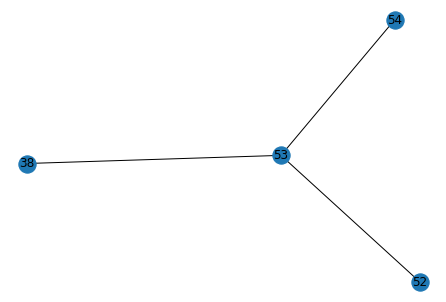

match_branches = [[38, 54], [52, 53]]
edges_to_delete (resolve crossover) = [[38, 52], [38, 53], [52, 54], [53, 54]]
edges_to_create (resolve crossover) = [[38, 54], [52, 53]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 104 because skeletal distance was 68.61021092295576 and threshold was 2500
skip_nodes = [104]
edges_to_delete (cut_limb_network) = [[38, 52], [38, 53], [52, 54], [53, 54]]
edges_to_create = [[38, 54], [52, 53]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 49, 50, 54, 57, 58, 59, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 13

  Edge: [101  99]: curr_angle = 27.17
  Edge: [99 92]: curr_angle = 9.82
  Edge: [92 85]: curr_angle = 9.36
  Edge: [85 79]: curr_angle = 14.62
  Edge: [79 75]: curr_angle = 8.95
  Edge: [75 68]: curr_angle = 24.64
  Edge: [68 64]: curr_angle = 29.66
  Edge: [64 49]: curr_angle = 8.1
  Edge: [49 46]: curr_angle = 6.45
  Edge: [46 43]: curr_angle = 22.48
  Edge: [43 37]: curr_angle = 12.44
  Edge: [37 34]: curr_angle = 17.75
  Edge: [34 33]: curr_angle = 9.76
  Edge: [33 27]: curr_angle = 11.24
  Edge: [27 31]: curr_angle = 32.61
  Edge: [31 62]: curr_angle = 9.08
  Edge: [62 61]: curr_angle = 35.41
  Edge: [61 72]: curr_angle = 16.28
  Edge: [ 72 125]: curr_angle = 46.71
  Edge: [125 135]: curr_angle = 77.33
  Edge: [135 155]: curr_angle = 49.22
  Edge: [155 154]: curr_angle = 19.54
  Edge: [154 153]: curr_angle = 35.32

Total time for doubling_back = 1.3932998180389404

Attempting the width jump check (attempting from both sides)
  Edge: [101  99]: jump = -30.05
  Edge: [99 92]: jump 

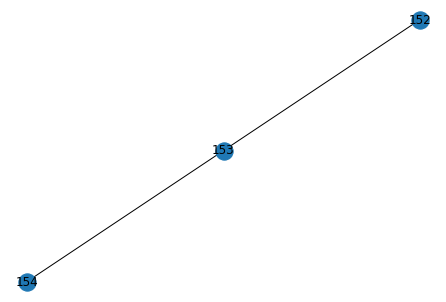

match_branches = []
edges_to_delete (resolve crossover) = [[152, 153], [152, 154], [153, 154]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([152, 153]), array([152, 154]), array([153, 154])]
edges_to_create = []
Number of connected components = 5
Comp 0 = {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 49, 50, 54, 57, 59, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 134, 135, 136, 137, 138, 146, 149, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166}
Comp 1 = {4, 45, 78, 47, 48, 51, 52, 53, 56, 25, 60, 63}
Comp 2 = {129, 131, 132, 133, 139, 140, 141, 142, 143, 144, 145, 147, 148, 150, 151, 152

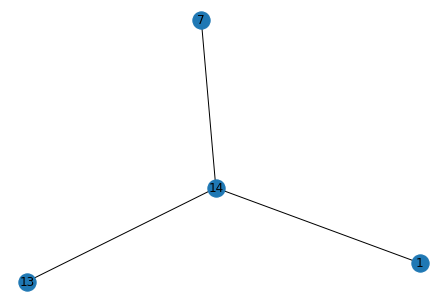

match_branches = [[1, 14]]
edges_to_delete (resolve crossover) = [[1, 7], [1, 13], [7, 13], [7, 14], [13, 14]]
edges_to_create (resolve crossover) = [[1, 14]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 7], [1, 13], [7, 13], [7, 14], [13, 14]]
edges_to_create = [[1, 14]]
Number of connected components = 2
Comp 0 = {1, 4, 9, 13, 14, 15, 17, 18, 19, 20, 23, 24, 25, 26, 27}
Comp 1 = {0, 2, 3, 5, 6, 7, 8, 10, 11, 12, 16, 21, 22}
curr_limb_copy.deleted_edges = [[1, 7], [1, 13], [7, 13], [7, 14], [13, 14]]
curr_limb_copy.created_edges = [[1, 14]]
After get best cut: cut_edges = [[1, 7], [1, 13], [7, 13], [7, 14], [13, 14]], added_edges = [[1, 14]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of 

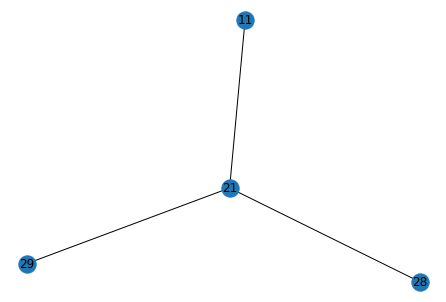

match_branches = [[21, 28]]
edges_to_delete (resolve crossover) = [[11, 21], [11, 28], [11, 29], [21, 29], [28, 29]]
edges_to_create (resolve crossover) = [[21, 28]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 73 because skeletal distance was 105.96606355958694 and threshold was 2500
skip_nodes = [73]
edges_to_delete (cut_limb_network) = [[11, 21], [11, 28], [11, 29], [21, 29], [28, 29]]
edges_to_create = [[21, 28]]
Number of connected components = 3
Comp 0 = {71, 9, 74, 47, 29}
Comp 1 = {11}
Comp 2 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76}
curr_limb_copy.deleted_edges = [[11, 21], [11, 28], [11, 29], [21, 29], [28, 29]]
curr_limb_copy.created_edges = [[21, 28]]
After get best cut: cut_edges = [[11, 21], [11, 28], [11, 29], [21, 29], [28, 29]], added_

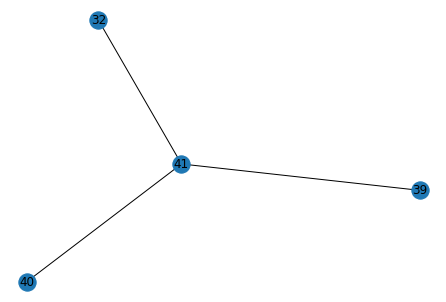

match_branches = [[32, 41]]
edges_to_delete (resolve crossover) = [[32, 39], [32, 40], [39, 40], [39, 41], [40, 41]]
edges_to_create (resolve crossover) = [[32, 41]]
curr_limb.deleted_edges 5 =[[11, 21], [11, 28], [11, 29], [21, 29], [28, 29]]
Skipping endnode 73 because skeletal distance was 105.96606355958694 and threshold was 2500
skip_nodes = [73]
edges_to_delete (cut_limb_network) = [[32, 39], [32, 40], [39, 40], [39, 41], [40, 41]]
edges_to_create = [[32, 41]]
Number of connected components = 5
Comp 0 = {71, 9, 74, 47, 29}
Comp 1 = {11}
Comp 2 = {4, 8, 12, 13, 15, 16, 21, 25, 28, 32, 34, 35, 36, 41, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 65, 66, 68, 72, 73}
Comp 3 = {0, 1, 2, 3, 5, 6, 7, 10, 14, 17, 18, 19, 20, 22, 23, 24, 26, 27, 30, 31, 33, 37, 38, 39, 42, 43, 44, 45, 46, 61, 62, 63, 67, 75, 76}
Comp 4 = {40, 69, 70}
curr_limb_copy.deleted_edges = [[11, 21], [11, 28], [11, 29], [21, 29], [28, 29], [32, 39], [32, 40], [39, 40], [39, 41], [40, 41]]
curr_limb_copy

  Edge: [60 57]: curr_angle = 62.22
  Edge: [57 54]: curr_angle = 27.89
  Edge: [54 53]: curr_angle = 12.9
  Edge: [53 41]: curr_angle = 7.12
  Edge: [41 32]: curr_angle = 19.32
  Edge: [32 21]: curr_angle = 36.15
  Edge: [21 28]: curr_angle = 10.17
  Edge: [28 34]: curr_angle = 3.04
  Edge: [34 36]: curr_angle = 130.36
  Edge: [36 72]: curr_angle = 37.14

Total time for doubling_back = 1.2972667217254639
There were 1 edges that passed doubling back threshold of 100
Winning edge [34 36] had a doubling back of 130.35759779681874
***inside resolve crossover!!!!****
coordinate_branches = [12, 34, 36]
12 = red
34 = aqua
36 = purple
Angle between 12 and 34 = 14.15 
Angle between 12 and 36 = 48.62 
Angle between 34 and 36 = 139.17 
Final Matches = [[12, 34]]
matched_branches_revised = [[12, 34]]
Original graph


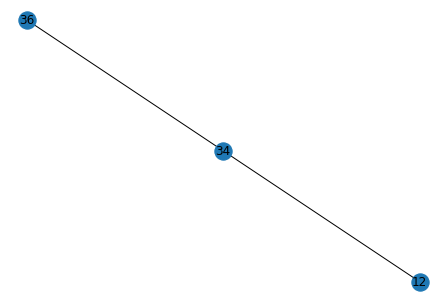

match_branches = [[12, 34]]
edges_to_delete (resolve crossover) = [[12, 36], [34, 36]]
edges_to_create (resolve crossover) = [[12, 34]]
edges_to_delete (cut_limb_network) = [array([12, 36]), array([34, 36])]
edges_to_create = [[12, 34]]
Number of connected components = 6
Comp 0 = {71, 9, 74, 47, 29}
Comp 1 = {11}
Comp 2 = {4, 12, 13, 21, 28, 32, 34, 35, 41, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}
Comp 3 = {0, 1, 2, 3, 5, 6, 7, 10, 14, 17, 18, 19, 20, 22, 23, 24, 26, 27, 30, 31, 33, 37, 38, 39, 42, 43, 44, 45, 46, 61, 62, 63, 67, 75, 76}
Comp 4 = {40, 69, 70}
Comp 5 = {64, 65, 66, 36, 68, 72, 73, 8, 15, 16, 25}
curr_limb_copy.deleted_edges = [[11, 21], [11, 28], [11, 29], [21, 29], [28, 29], [32, 39], [32, 40], [39, 40], [39, 41], [40, 41], array([12, 36]), array([34, 36])]
curr_limb_copy.created_edges = [[21, 28], [32, 41], [12, 34]]
After get best cut: cut_edges = [array([12, 36]), array([34, 36])], added_edges = [[12, 34]]
total_soma_paths_to_cut = [[11, 21], [11, 28], [1

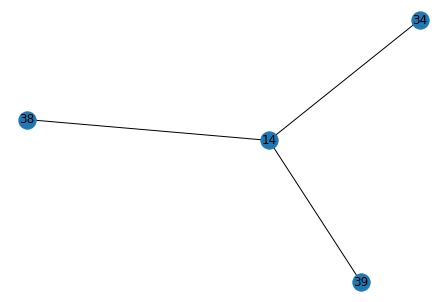

match_branches = []
edges_to_delete (resolve crossover) = [[14, 34], [14, 38], [14, 39], [34, 38], [34, 39], [38, 39]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[]
Skipping endnode 19 because skeletal distance was 606.7223108259434 and threshold was 2500
skip_nodes = [19]
edges_to_delete (cut_limb_network) = [[14, 34], [14, 38], [14, 39], [34, 38], [34, 39], [38, 39]]
edges_to_create = []
Number of connected components = 5
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 41, 42, 43, 44}
Comp 1 = {33, 34, 23}
Comp 2 = {38}
Comp 3 = {39}
Comp 4 = {40}
curr_limb_copy.deleted_edges = [[14, 34], [14, 38], [14, 39], [34, 38], [34, 39], [38, 39]]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [[14, 34], [14, 38], [14, 39], [34, 38], [34, 39], [38, 39]], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total num

  Edge: [63 62]: curr_angle = 39.95
  Edge: [62 61]: curr_angle = 142.18
  Edge: [61 65]: curr_angle = 43.61

Total time for doubling_back = 0.10457420349121094
There were 1 edges that passed doubling back threshold of 100
Winning edge [62 61] had a doubling back of 142.18346466249776
***inside resolve crossover!!!!****
coordinate_branches = [44, 61, 62]
44 = red
61 = aqua
62 = purple
Angle between 44 and 61 = 37.87 
Angle between 44 and 62 = 5.08 
Angle between 61 and 62 = 137.56 
Final Matches = [[44, 62]]
matched_branches_revised = [[44, 62]]
Original graph


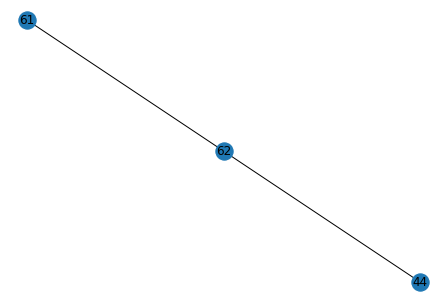

match_branches = [[44, 62]]
edges_to_delete (resolve crossover) = [[44, 61], [61, 62]]
edges_to_create (resolve crossover) = [[44, 62]]
edges_to_delete (cut_limb_network) = [array([44, 61]), array([61, 62])]
edges_to_create = [[44, 62]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 60, 62, 63}
Comp 1 = {64, 65, 58, 59, 61}
curr_limb_copy.deleted_edges = [array([44, 61]), array([61, 62])]
curr_limb_copy.created_edges = [[44, 62]]
After get best cut: cut_edges = [array([44, 61]), array([61, 62])], added_edges = [[44, 62]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the 

  Edge: [3 4]: curr_angle = 132.03

Total time for doubling_back = 0.10585522651672363
There were 1 edges that passed doubling back threshold of 100
Winning edge [3 4] had a doubling back of 132.0333837011951
***inside resolve crossover!!!!****
coordinate_branches = [3, 4, 5]
3 = red
4 = aqua
5 = purple
Angle between 3 and 4 = 141.57 
Angle between 3 and 5 = 26.93 
Angle between 4 and 5 = 48.73 
Final Matches = [[3, 5]]
matched_branches_revised = [[3, 5]]
Original graph


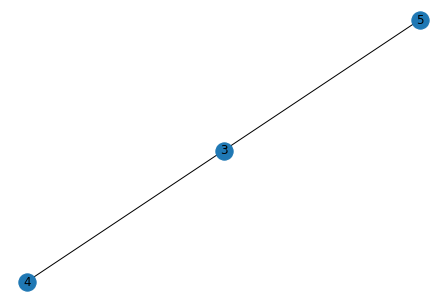

match_branches = [[3, 5]]
edges_to_delete (resolve crossover) = [[3, 4], [4, 5]]
edges_to_create (resolve crossover) = [[3, 5]]
edges_to_delete (cut_limb_network) = [array([3, 4]), array([4, 5])]
edges_to_create = [[3, 5]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13}
Comp 1 = {4}
curr_limb_copy.deleted_edges = [array([3, 4]), array([4, 5])]
curr_limb_copy.created_edges = [[3, 5]]
After get best cut: cut_edges = [array([3, 4]), array([4, 5])], added_edges = [[3, 5]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([4])]


 -------- Working on limb 8------------
Starting combinations to process = [[ 8 10]]


---

  Edge: [8 7]: curr_angle = 19.71
  Edge: [7 4]: curr_angle = 49.3
  Edge: [4 5]: curr_angle = 161.16
  Edge: [ 5 10]: curr_angle = 43.11

Total time for doubling_back = 0.21330523490905762
There were 1 edges that passed doubling back threshold of 100
Winning edge [4 5] had a doubling back of 161.16345145666392
***inside resolve crossover!!!!****
coordinate_branches = [2, 4, 5]
2 = red
4 = aqua
5 = purple
Angle between 2 and 4 = 44.86 
Angle between 2 and 5 = 26.51 
Angle between 4 and 5 = 129.69 
Final Matches = [[2, 5]]
matched_branches_revised = [[2, 5]]
Original graph


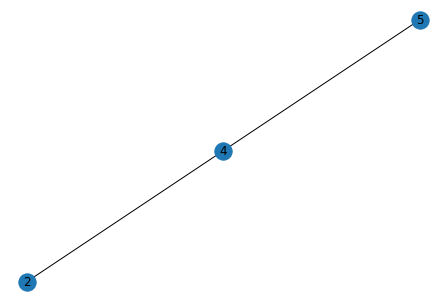

match_branches = [[2, 5]]
edges_to_delete (resolve crossover) = [[2, 4], [4, 5]]
edges_to_create (resolve crossover) = [[2, 5]]
edges_to_delete (cut_limb_network) = [array([2, 4]), array([4, 5])]
edges_to_create = [[2, 5]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 5, 9, 10}
Comp 1 = {3, 4, 6, 7, 8}
curr_limb_copy.deleted_edges = [array([2, 4]), array([4, 5])]
curr_limb_copy.created_edges = [[2, 5]]
After get best cut: cut_edges = [array([2, 4]), array([4, 5])], added_edges = [[2, 5]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  5,  9, 10]), array([3, 4, 6, 7, 8])]


 ------ Total time for Splitting 864691136618586765 = 205.56832885742188 ------


----- Working on Neuron 864691135609

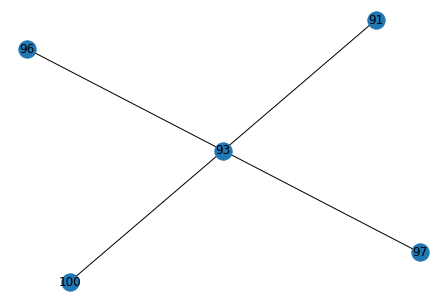

match_branches = [[91, 97]]
edges_to_delete (resolve crossover) = [[91, 93], [91, 96], [91, 100], [93, 96], [93, 97], [93, 100], [96, 97], [96, 100], [97, 100]]
edges_to_create (resolve crossover) = [[91, 97]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[91, 93], [91, 96], [91, 100], [93, 96], [93, 97], [93, 100], [96, 97], [96, 100], [97, 100]]
edges_to_create = [[91, 97]]
Number of connected components = 5
Comp 0 = {97, 91}
Comp 1 = {90, 73, 74, 75, 76, 77, 61, 83, 85, 86, 87, 88, 89, 58, 59, 92, 93, 63}
Comp 2 = {96}
Comp 3 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 60, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 78, 79, 80, 81, 82, 84, 94, 95, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116}
Comp 4 = {98}
curr_limb_copy.deleted_

  Edge: [0 2]: curr_angle = 44.59

Total time for doubling_back = 0.2396068572998047

Attempting the width jump check (attempting from both sides)
  Edge: [0 2]: jump = -118.68
Total time for width = 0.2159590721130371
Path starting at 0 had err_edges: []
  Edge: [2 0]: jump = 118.68
Total time for width = 0.21832537651062012
Path starting at 2 had err_edges: []
Did not find an error edge in either of the paths
Number of connected components = 1
Comp 0 = {0, 1, 2}
curr_limb_copy.deleted_edges = []
curr_limb_copy.created_edges = []
After get best cut: cut_edges = None, added_edges = []
***** there was no suggested cut for this limb even though it is still connnected***
Total number of graphs at the end of the split = 1: [array([0, 1, 2])]


 ------ Total time for Splitting 864691135609493511 = 202.69317078590393 ------


----- Working on Neuron 864691135467600268-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = [0 1 3]
multi_touch_limbs = [0 1 3]


 --

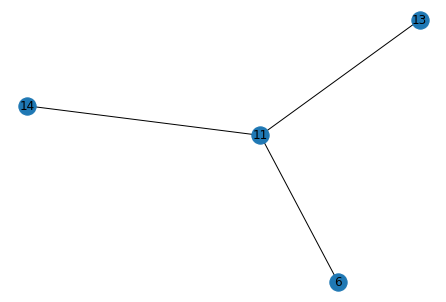

match_branches = [[11, 14], [6, 13]]
edges_to_delete (resolve crossover) = [[6, 11], [6, 14], [11, 13], [13, 14]]
edges_to_create (resolve crossover) = [[11, 14], [6, 13]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[6, 11], [6, 14], [11, 13], [13, 14]]
edges_to_create = [[11, 14], [6, 13]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 8, 9, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27.0, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
Comp 1 = {10, 11, 14, 7}
Comp 2 = {12}
curr_limb_copy.deleted_edges = [[6, 11], [6, 14], [11, 13], [13, 14]]
curr_limb_copy.created_edges = [[11, 14], [6, 13]]
After get best cut: cut_edges = [[6, 11], [6, 14], [11, 13], [13, 14]], added_edges = [[11, 14], [6, 13]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end

  Edge: [41 37]: curr_angle = 39.66
  Edge: [37 29]: curr_angle = 21.56
  Edge: [29 26]: curr_angle = 21.73
  Edge: [26 35]: curr_angle = 144.64
  Edge: [35 36]: curr_angle = 29.74
  Edge: [36 42]: curr_angle = 29.01

Total time for doubling_back = 0.17217516899108887
There were 1 edges that passed doubling back threshold of 100
Winning edge [26 35] had a doubling back of 144.63738466594023
***inside resolve crossover!!!!****
coordinate_branches = [26, 32, 35]
26 = red
32 = aqua
35 = purple
Angle between 26 and 32 = 15.26 
Angle between 26 and 35 = 160.41 
Angle between 32 and 35 = 24.44 
Final Matches = [[26, 32], [32, 35]]
matched_branches_revised = [[26, 32]]
Original graph


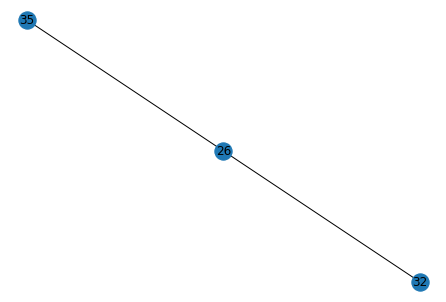

match_branches = [[26, 32]]
edges_to_delete (resolve crossover) = [[26, 35], [32, 35]]
edges_to_create (resolve crossover) = [[26, 32]]
edges_to_delete (cut_limb_network) = [array([26, 35]), array([32, 35])]
edges_to_create = [[26, 32]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 8, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27.0, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 44, 45, 46, 47, 48, 49}
Comp 1 = {35, 36, 6, 42, 43, 13}
Comp 2 = {10, 11, 14, 7}
Comp 3 = {12}
curr_limb_copy.deleted_edges = [[6, 11], [6, 14], [11, 13], [13, 14], array([26, 35]), array([32, 35])]
curr_limb_copy.created_edges = [[11, 14], [6, 13], [26, 32]]
After get best cut: cut_edges = [array([26, 35]), array([32, 35])], added_edges = [[26, 32]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so m

  Edge: [18 11]: curr_angle = 56.67
  Edge: [11  9]: curr_angle = 101.9
  Edge: [9 8]: curr_angle = 81.46
  Edge: [ 8 29]: curr_angle = 34.09
  Edge: [29 21]: curr_angle = 113.89

Total time for doubling_back = 0.6954970359802246
There were 2 edges that passed doubling back threshold of 100
Winning edge [29 21] had a doubling back of 113.88868180180333
***inside resolve crossover!!!!****
coordinate_branches = [21, 27, 29]
21 = red
27 = aqua
29 = purple
Angle between 21 and 27 = 38.48 
Angle between 21 and 29 = 116.9 
Angle between 27 and 29 = 69.57 
Final Matches = []
matched_branches_revised = []
Original graph


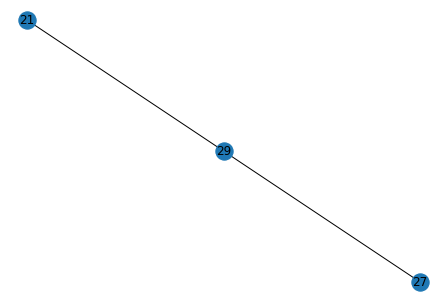

match_branches = []
edges_to_delete (resolve crossover) = [[21, 27], [21, 29], [27, 29]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([21, 27]), array([21, 29]), array([27, 29])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 29, 30}
Comp 1 = {21}
Comp 2 = {0, 7, 14, 15, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38}
curr_limb_copy.deleted_edges = [array([21, 27]), array([21, 29]), array([27, 29])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([21, 27]), array([21, 29]), array([27, 29])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconnecting 18 and 34
---- This disconnec

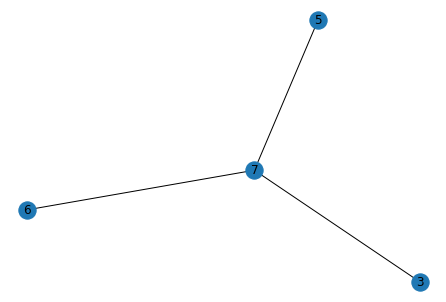

match_branches = [[3, 6]]
edges_to_delete (resolve crossover) = [[3, 5], [3, 7], [5, 6], [5, 7], [6, 7]]
edges_to_create (resolve crossover) = [[3, 6]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 6 because skeletal distance was 708.0931326650463 and threshold was 2500
skip_nodes = [6]
edges_to_delete (cut_limb_network) = [[3, 5], [3, 7], [5, 6], [5, 7], [6, 7]]
edges_to_create = [[3, 6]]
Number of connected components = 3
Comp 0 = {0, 3, 4, 6}
Comp 1 = {11, 12, 5}
Comp 2 = {1, 2, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
curr_limb_copy.deleted_edges = [[3, 5], [3, 7], [5, 6], [5, 7], [6, 7]]
curr_limb_copy.created_edges = [[3, 6]]
After get best cut: cut_edges = [[3, 5], [3, 7], [5, 6], [5, 7], [6, 7]], added_edges = [[3, 6]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
Shortest path = [4

  Edge: [4 3]: curr_angle = 93.86

Total time for doubling_back = 0.0445704460144043

Attempting the width jump check (attempting from both sides)
  Edge: [4 3]: jump = 216.81
Adding error edge [4 3] because width jump was 216.81292516730267
Total time for width = 0.017623186111450195
Path starting at 4 had err_edges: [[4, 3]]
  Edge: [3 4]: jump = -216.81
Total time for width = 0.016598224639892578
Path starting at 6 had err_edges: []
first_error_sizes = [216.81292516730267, -inf], winning_path = 0
***inside resolve crossover!!!!****
coordinate_branches = [0, 3, 4]
0 = red
3 = aqua
4 = purple
Angle between 0 and 3 = 1.98 
Angle between 0 and 4 = 83.33 
Angle between 3 and 4 = 95.29 
Final Matches = [[0, 3]]
matched_branches_revised = [[0, 3]]
Original graph


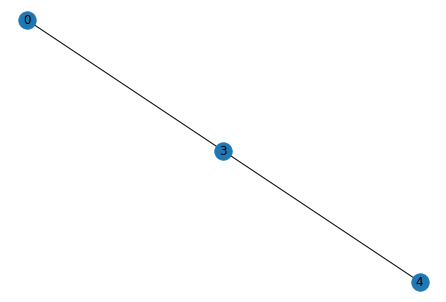

match_branches = [[0, 3]]
edges_to_delete (resolve crossover) = [[0, 4], [3, 4]]
edges_to_create (resolve crossover) = [[0, 3]]
edges_to_delete (cut_limb_network) = [array([0, 4]), array([3, 4])]
edges_to_create = [[0, 3]]
Number of connected components = 4
Comp 0 = {0, 3, 6}
Comp 1 = {11, 12, 5}
Comp 2 = {1, 2, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
Comp 3 = {4}
curr_limb_copy.deleted_edges = [[3, 5], [3, 7], [5, 6], [5, 7], [6, 7], array([0, 4]), array([3, 4])]
curr_limb_copy.created_edges = [[3, 6], [0, 3]]
After get best cut: cut_edges = [array([0, 4]), array([3, 4])], added_edges = [[0, 3]]
total_soma_paths_to_cut = [[3, 5], [3, 7], [5, 6], [5, 7], [6, 7]]
-----------counter = 1------------
 Cut iteration 2
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connection


---- working on disconnecting 4 and 8
---- This disconnects S1

  Edge: [ 8 10]: curr_angle = 39.19
  Edge: [10 12]: curr_angle = 20.88
  Edge: [12 13]: curr_angle = 29.11
  Edge: [13  3]: curr_angle = 115.96
  Edge: [3 4]: curr_angle = 100.0
  Edge: [ 4 11]: curr_angle = 65.77

Total time for doubling_back = 0.25902652740478516
There were 2 edges that passed doubling back threshold of 100
Winning edge [13  3] had a doubling back of 115.96099118355389
***inside resolve crossover!!!!****
coordinate_branches = [3, 13, 16]
3 = red
13 = aqua
16 = purple
Angle between 3 and 13 = 125.11 
Angle between 3 and 16 = 32.19 
Angle between 13 and 16 = 85.26 
Final Matches = [[3, 16]]
matched_branches_revised = [[3, 16]]
Original graph


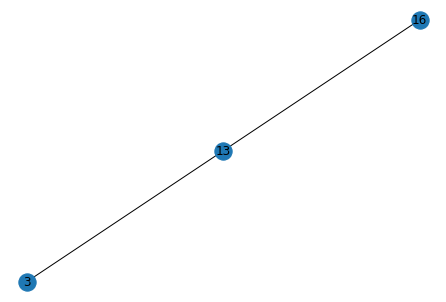

match_branches = [[3, 16]]
edges_to_delete (resolve crossover) = [[3, 13], [13, 16]]
edges_to_create (resolve crossover) = [[3, 16]]
edges_to_delete (cut_limb_network) = [array([ 3, 13]), array([13, 16])]
edges_to_create = [[3, 16]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 6, 9, 11, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67}
Comp 1 = {5, 7, 8, 10, 12, 13, 14, 17, 18}
curr_limb_copy.deleted_edges = [array([ 3, 13]), array([13, 16])]
curr_limb_copy.created_edges = [[3, 16]]
After get best cut: cut_edges = [array([ 3, 13]), array([13, 16])], added_edges = [[3, 16]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto th

  Edge: [11  4]: curr_angle = 63.96
  Edge: [4 3]: curr_angle = 86.1
  Edge: [ 3 16]: curr_angle = 19.01
  Edge: [16 38]: curr_angle = 37.2
  Edge: [38 37]: curr_angle = 20.86
  Edge: [37 36]: curr_angle = 27.34
  Edge: [36 32]: curr_angle = 117.55
  Edge: [32 33]: curr_angle = 168.1
  Edge: [33 30]: curr_angle = 131.62

Total time for doubling_back = 0.43117761611938477
There were 3 edges that passed doubling back threshold of 100
Winning edge [32 33] had a doubling back of 168.0960011479607
***inside resolve crossover!!!!****
coordinate_branches = [31, 32, 33]
31 = red
32 = aqua
33 = purple
Angle between 31 and 32 = 74.69 
Angle between 31 and 33 = 65.68 
Angle between 32 and 33 = 168.1 
Final Matches = []
matched_branches_revised = []
Original graph


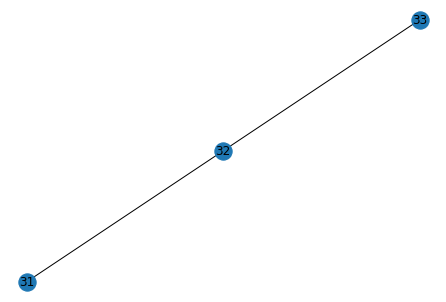

match_branches = []
edges_to_delete (resolve crossover) = [[31, 32], [31, 33], [32, 33]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([31, 32]), array([31, 33]), array([32, 33])]
edges_to_create = []
Number of connected components = 4
Comp 0 = {33, 34, 6, 9, 42, 41, 46, 26, 28, 30}
Comp 1 = {0, 35, 39, 47, 15, 49, 51, 20, 21, 23, 24, 27, 31}
Comp 2 = {1, 2, 3, 4, 11, 16, 19, 22, 25, 29, 32, 36, 37, 38, 40, 43, 44, 45, 48, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67}
Comp 3 = {5, 7, 8, 10, 12, 13, 14, 17, 18}
curr_limb_copy.deleted_edges = [array([ 3, 13]), array([13, 16]), array([31, 32]), array([31, 33]), array([32, 33])]
curr_limb_copy.created_edges = [[3, 16]]
After get best cut: cut_edges = [array([31, 32]), array([31, 33]), array([32, 33])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number

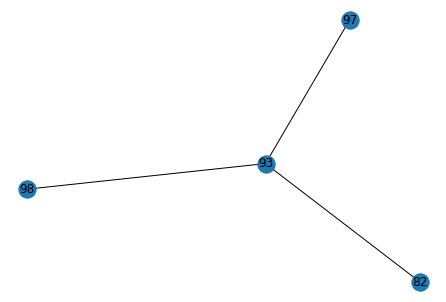

match_branches = [[82, 98], [93, 97]]
edges_to_delete (resolve crossover) = [[82, 93], [82, 97], [93, 98], [97, 98]]
edges_to_create (resolve crossover) = [[82, 98], [93, 97]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[82, 93], [82, 97], [93, 98], [97, 98]]
edges_to_create = [[82, 98], [93, 97]]
Number of connected components = 6
Comp 0 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 109, 110, 111, 112, 113, 114, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 

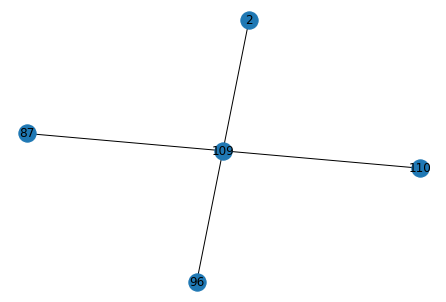

match_branches = [[96, 110]]
edges_to_delete (resolve crossover) = [[2, 87], [2, 96], [2, 109], [2, 110], [87, 96], [87, 109], [87, 110], [96, 109], [109, 110]]
edges_to_create (resolve crossover) = [[96, 110]]
curr_limb.deleted_edges 5 =[[82, 93], [82, 97], [93, 98], [97, 98]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[2, 87], [2, 96], [2, 109], [2, 110], [87, 96], [87, 109], [87, 110], [96, 109], [109, 110]]
edges_to_create = [[96, 110]]
Number of connected components = 9
Comp 0 = {130, 101, 105, 109, 49, 114, 113, 122, 126}
Comp 1 = {2}
Comp 2 = {87}
Comp 3 = {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 102, 103, 104, 106, 110, 111, 112, 117, 118, 119, 120

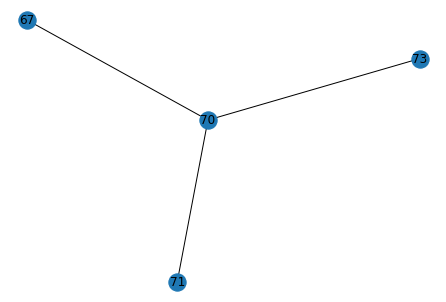

match_branches = []
edges_to_delete (resolve crossover) = [[67, 70], [67, 71], [67, 73], [70, 71], [70, 73], [71, 73]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[]
Skipping endnode 100 because skeletal distance was 1610.3339398033702 and threshold was 2500
skip_nodes = [100]
edges_to_delete (cut_limb_network) = [[67, 70], [67, 71], [67, 73], [70, 71], [70, 73], [71, 73]]
edges_to_create = []
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 72, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,

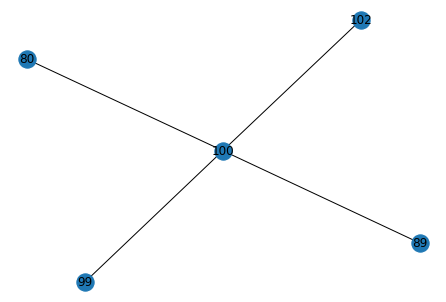

match_branches = [[99, 100], [80, 102]]
edges_to_delete (resolve crossover) = [[80, 89], [80, 99], [80, 100], [89, 99], [89, 100], [89, 102], [99, 102], [100, 102]]
edges_to_create (resolve crossover) = [[99, 100], [80, 102]]
curr_limb.deleted_edges 5 =[[67, 70], [67, 71], [67, 73], [70, 71], [70, 73], [71, 73]]
Skipping endnode 100 because skeletal distance was 1610.3339398033702 and threshold was 2500
skip_nodes = [100]
edges_to_delete (cut_limb_network) = [[80, 89], [80, 99], [80, 100], [89, 99], [89, 100], [89, 102], [99, 102], [100, 102]]
edges_to_create = [[99, 100], [80, 102]]
Number of connected components = 7
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 69, 74, 77, 78, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 

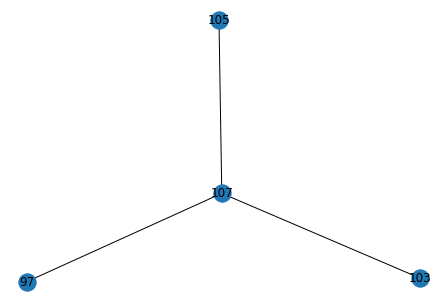

match_branches = [[103, 105]]
edges_to_delete (resolve crossover) = [[97, 103], [97, 105], [97, 107], [103, 107], [105, 107]]
edges_to_create (resolve crossover) = [[103, 105]]
curr_limb.deleted_edges 5 =[[67, 70], [67, 71], [67, 73], [70, 71], [70, 73], [71, 73], [80, 89], [80, 99], [80, 100], [89, 99], [89, 100], [89, 102], [99, 102], [100, 102]]
Skipping endnode 100 because skeletal distance was 1610.3339398033702 and threshold was 2500
skip_nodes = [100]
edges_to_delete (cut_limb_network) = [[97, 103], [97, 105], [97, 107], [103, 107], [105, 107]]
edges_to_create = [[103, 105]]
Number of connected components = 9
Comp 0 = {131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 5, 40, 44, 52, 56, 57, 58, 59, 60, 61, 62, 63, 69, 74, 77, 78, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 98, 103, 104, 105, 106, 108, 109, 110, 111, 112, 114, 115, 124, 126}
Comp 1 = {0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 141, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33

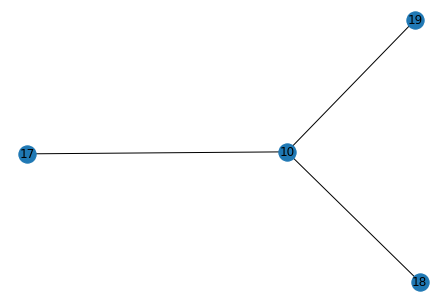

match_branches = [[10, 18]]
edges_to_delete (resolve crossover) = [[10, 17], [10, 19], [17, 18], [17, 19], [18, 19]]
edges_to_create (resolve crossover) = [[10, 18]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 9 because skeletal distance was 399.5301146248365 and threshold was 2500
skip_nodes = [9]
edges_to_delete (cut_limb_network) = [[10, 17], [10, 19], [17, 18], [17, 19], [18, 19]]
edges_to_create = [[10, 18]]
Number of connected components = 4
Comp 0 = {4, 5, 6, 7, 8, 9, 11, 12, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29}
Comp 1 = {10, 18}
Comp 2 = {0, 1, 2, 3, 13, 14, 17}
Comp 3 = {25}
curr_limb_copy.deleted_edges = [[10, 17], [10, 19], [17, 18], [17, 19], [18, 19]]
curr_limb_copy.created_edges = [[10, 18]]
After get best cut: cut_edges = [[10, 17], [10, 19], [17, 18], [17, 19], [18, 19]], added_edges = [[10, 18]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total numbe

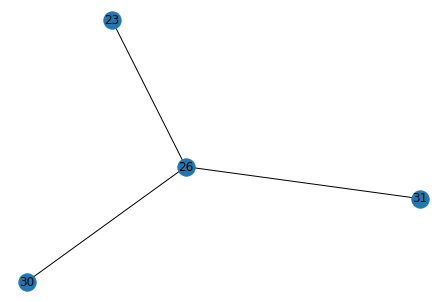

match_branches = [[26, 31]]
edges_to_delete (resolve crossover) = [[23, 26], [23, 30], [23, 31], [26, 30], [30, 31]]
edges_to_create (resolve crossover) = [[26, 31]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[23, 26], [23, 30], [23, 31], [26, 30], [30, 31]]
edges_to_create = [[26, 31]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}
Comp 1 = {3, 21, 23}
Comp 2 = {30}
Comp 3 = {29}
curr_limb_copy.deleted_edges = [[23, 26], [23, 30], [23, 31], [26, 30], [30, 31]]
curr_limb_copy.created_edges = [[26, 31]]
After get best cut: cut_edges = [[23, 26], [23, 30], [23, 31], [26, 30], [30, 31]], added_edges = [[26, 31]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end 

  Edge: [10  7]: curr_angle = 10.84
  Edge: [7 6]: curr_angle = 123.41
  Edge: [ 6 16]: curr_angle = 30.55
  Edge: [16 24]: curr_angle = 37.44
  Edge: [24 26]: curr_angle = 11.08
  Edge: [26 31]: curr_angle = 20.38
  Edge: [31 37]: curr_angle = 40.76
  Edge: [37 34]: curr_angle = 38.62

Total time for doubling_back = 0.6301074028015137
There were 1 edges that passed doubling back threshold of 100
Winning edge [7 6] had a doubling back of 123.41291405458064
***inside resolve crossover!!!!****
coordinate_branches = [5, 6, 7]
5 = red
6 = aqua
7 = purple
Angle between 5 and 6 = 25.0 
Angle between 5 and 7 = 49.17 
Angle between 6 and 7 = 107.54 
Final Matches = [[5, 6]]
matched_branches_revised = [[5, 6]]
Original graph


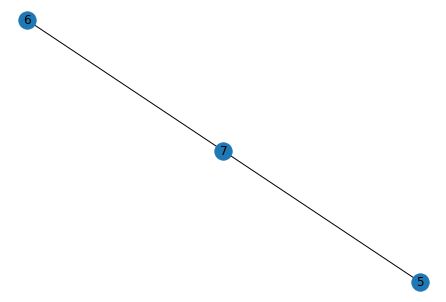

match_branches = [[5, 6]]
edges_to_delete (resolve crossover) = [[5, 7], [6, 7]]
edges_to_create (resolve crossover) = [[5, 6]]
edges_to_delete (cut_limb_network) = [array([5, 7]), array([6, 7])]
edges_to_create = [[5, 6]]
Number of connected components = 5
Comp 0 = {0, 1, 2, 4, 5, 6, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}
Comp 1 = {3, 21, 23}
Comp 2 = {30}
Comp 3 = {9, 10, 7}
Comp 4 = {29}
curr_limb_copy.deleted_edges = [[23, 26], [23, 30], [23, 31], [26, 30], [30, 31], array([5, 7]), array([6, 7])]
curr_limb_copy.created_edges = [[26, 31], [5, 6]]
After get best cut: cut_edges = [array([5, 7]), array([6, 7])], added_edges = [[5, 6]]
total_soma_paths_to_cut = [[23, 26], [23, 30], [23, 31], [26, 30], [30, 31]]
-----------counter = 1------------
 Cut iteration 2
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 5
Total number of graphs at the end of the split AFTER DIRECTIONAL =

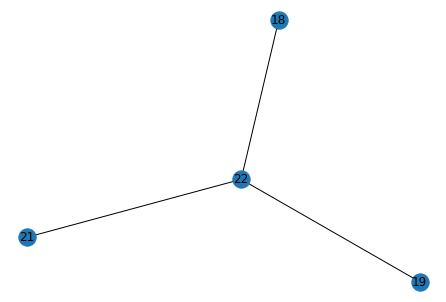

match_branches = [[19, 22]]
edges_to_delete (resolve crossover) = [[18, 19], [18, 21], [18, 22], [19, 21], [21, 22]]
edges_to_create (resolve crossover) = [[19, 22]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 22 because skeletal distance was 1371.274222854659 and threshold was 2500
skip_nodes = [22]
edges_to_delete (cut_limb_network) = [[18, 19], [18, 21], [18, 22], [19, 21], [21, 22]]
edges_to_create = [[19, 22]]
Number of connected components = 4
Comp 0 = {6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 19, 22, 23, 24, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52}
Comp 1 = {0, 1, 2, 3, 4, 5, 12, 16, 18}
Comp 2 = {25, 29, 21, 30}
Comp 3 = {20}
curr_limb_copy.deleted_edges = [[18, 19], [18, 21], [18, 22], [19, 21], [21, 22]]
curr_limb_copy.created_edges = [[19, 22]]
After get best cut: cut_edges = [[18, 19], [18, 21], [18, 22], [19, 21], [21, 22]], added_edges = [[19, 22]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut

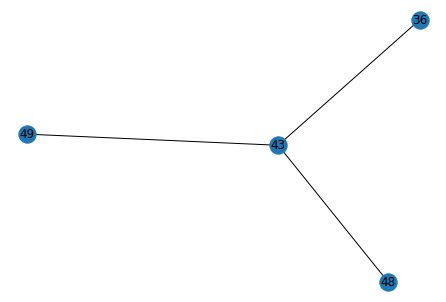

match_branches = [[43, 48]]
edges_to_delete (resolve crossover) = [[36, 43], [36, 48], [36, 49], [43, 49], [48, 49]]
edges_to_create (resolve crossover) = [[43, 48]]
curr_limb.deleted_edges 5 =[[18, 19], [18, 21], [18, 22], [19, 21], [21, 22]]
Skipping endnode 22 because skeletal distance was 1371.274222854659 and threshold was 2500
skip_nodes = [22]
edges_to_delete (cut_limb_network) = [[36, 43], [36, 48], [36, 49], [43, 49], [48, 49]]
edges_to_create = [[43, 48]]
Number of connected components = 6
Comp 0 = {6, 7, 8, 9, 10, 13, 14, 15, 17, 24, 26, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 51, 52}
Comp 1 = {43, 44, 11, 48, 19, 22, 23, 27, 28}
Comp 2 = {49, 50, 47}
Comp 3 = {0, 1, 2, 3, 4, 5, 12, 16, 18}
Comp 4 = {25, 29, 21, 30}
Comp 5 = {20}
curr_limb_copy.deleted_edges = [[18, 19], [18, 21], [18, 22], [19, 21], [21, 22], [36, 43], [36, 48], [36, 49], [43, 49], [48, 49]]
curr_limb_copy.created_edges = [[19, 22], [43, 48]]
After get best cut: cut_edges = [[36, 43], [36, 4

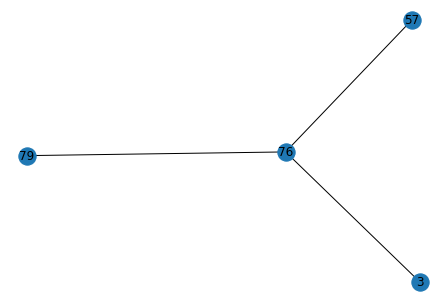

match_branches = [[57, 76]]
edges_to_delete (resolve crossover) = [[3, 57], [3, 76], [3, 79], [57, 79], [76, 79]]
edges_to_create (resolve crossover) = [[57, 76]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[3, 57], [3, 76], [3, 79], [57, 79], [76, 79]]
edges_to_create = [[57, 76]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128}
Comp 1 = {3}
Comp 2 = {77}
Comp 3 = {87}
curr_limb_copy.deleted_edges = [[3, 57], [3, 76], [3, 79], [57, 79]

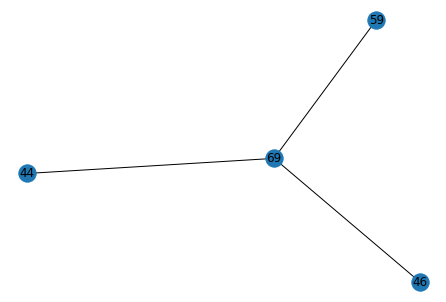

match_branches = [[59, 69]]
edges_to_delete (resolve crossover) = [[44, 46], [44, 59], [44, 69], [46, 59], [46, 69]]
edges_to_create (resolve crossover) = [[59, 69]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[44, 46], [44, 59], [44, 69], [46, 59], [46, 69]]
edges_to_create = [[59, 69]]
Number of connected components = 6
Comp 0 = {0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128}
Comp 1 = {3}
Comp 2 = {44}
Comp 3 = {46}
Comp 4 = {77}
Comp 5 = {

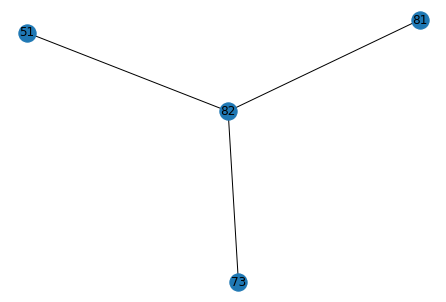

match_branches = [[51, 81], [73, 82]]
edges_to_delete (resolve crossover) = [[51, 73], [51, 82], [73, 81], [81, 82]]
edges_to_create (resolve crossover) = [[51, 81], [73, 82]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[51, 73], [51, 82], [73, 81], [81, 82]]
edges_to_create = [[51, 81], [73, 82]]
Number of connected components = 7
Comp 0 = {0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 42, 45, 47, 49, 52, 53, 54, 55, 57, 61, 62, 63, 70, 71, 73, 76, 78, 82, 86, 93, 101, 102, 103, 104, 107, 108, 109, 111, 112, 113, 114, 115, 117, 118}
Comp 1 = {3}
Comp 2 = {128, 2, 9, 38, 41, 43, 48, 50, 51, 56, 58, 59, 60, 64, 65, 66, 67, 68, 69, 72, 74, 75, 79, 80, 81, 83, 84, 85, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 105, 106, 110, 116, 119, 120, 121, 122, 123, 12

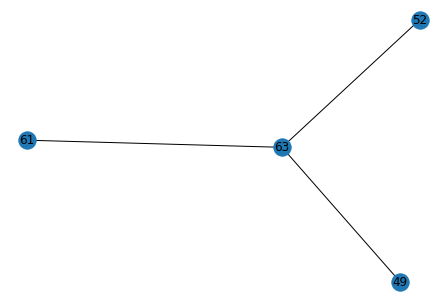

match_branches = [[52, 63]]
edges_to_delete (resolve crossover) = [[49, 52], [49, 61], [49, 63], [52, 61], [61, 63]]
edges_to_create (resolve crossover) = [[52, 63]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[49, 52], [49, 61], [49, 63], [52, 61], [61, 63]]
edges_to_create = [[52, 63]]
Number of connected components = 10
Comp 0 = {0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 40, 42, 45, 47, 52, 53, 54, 55, 57, 63, 73, 76, 82, 86}
Comp 1 = {3}
Comp 2 = {128, 2, 9, 38, 41, 43, 48, 50, 51, 56, 58, 59, 60, 64, 65, 66, 67, 68, 69, 72, 74, 75, 79, 80, 81, 83, 84, 85, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 105, 106, 110, 116, 119, 120, 121, 122, 123, 124, 125, 126, 127}
Comp 3 = {49}
Comp 4 = {18, 36, 37, 61, 70, 71, 78, 93, 101, 

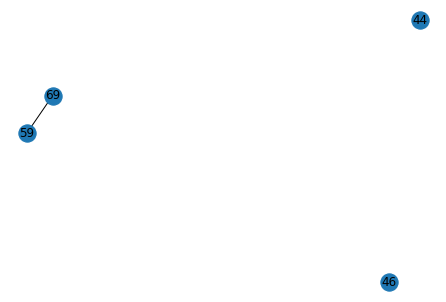

match_branches = [[59, 69]]
edges_to_delete (resolve crossover) = [[44, 46], [44, 59], [44, 69], [46, 59], [46, 69]]
edges_to_create (resolve crossover) = [[59, 69]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[44, 46], [44, 59], [44, 69], [46, 59], [46, 69]]
edges_to_create = [[59, 69]]
Number of connected components = 10
Comp 0 = {0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 40, 42, 45, 47, 52, 53, 54, 55, 57, 63, 73, 76, 82, 86}
Comp 1 = {3}
Comp 2 = {128, 2, 9, 38, 41, 43, 48, 50, 51, 56, 58, 59, 60, 64, 65, 66, 67, 68, 69, 72, 74, 75, 79, 80, 81, 83, 84, 85, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 105, 106, 110, 116, 119, 120, 121, 122, 123, 124, 125, 126, 127}
Comp 3 = {4

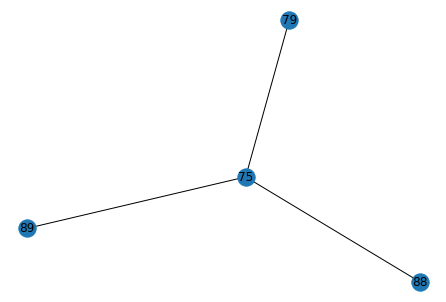

match_branches = [[75, 88]]
edges_to_delete (resolve crossover) = [[75, 79], [75, 89], [79, 88], [79, 89], [88, 89]]
edges_to_create (resolve crossover) = [[75, 88]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[75, 79], [75, 89], [79, 88], [79, 89], [88, 89]]
edges_to_create = [[75, 88]]
Number of connected components = 12
Comp 0 = {0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 40, 42, 45, 47, 52, 53, 54, 55, 57, 63, 73, 76, 82, 86}
Comp 1 = {3}
Comp 2 = {79}
Comp 3 = {128, 2, 9, 38, 41, 43, 48, 50, 51, 56, 58, 59, 60, 64, 65, 66, 67, 69, 74, 75, 81, 84, 85, 88, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 105, 106, 110, 116, 119, 120, 121, 1

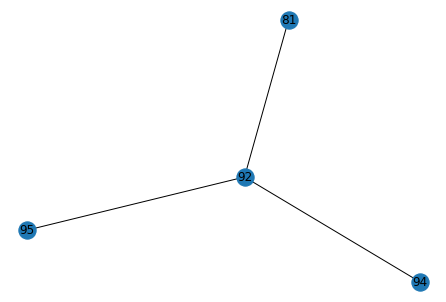

match_branches = [[81, 94], [92, 95]]
edges_to_delete (resolve crossover) = [[81, 92], [81, 95], [92, 94], [94, 95]]
edges_to_create (resolve crossover) = [[81, 94], [92, 95]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[81, 92], [81, 95], [92, 94], [94, 95]]
edges_to_create = [[81, 94], [92, 95]]
Number of connected components = 12
Comp 0 = {0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 40, 42, 45, 47, 52, 53, 54, 55, 57, 63, 73, 76, 82, 86}
Comp 1 = {3}
Comp 2 = {79}
Comp 3 = {128, 2, 9, 38, 41, 43, 48, 50, 51, 56, 58, 59, 60, 64, 65, 66, 67, 69, 74, 75, 81, 84, 85, 88, 90, 91, 92, 94, 9

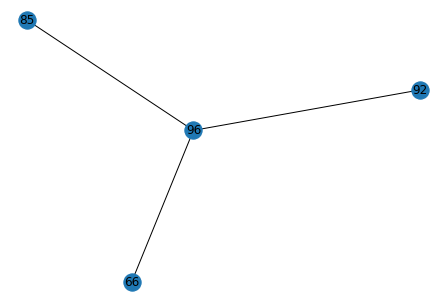

match_branches = [[85, 92], [66, 96]]
edges_to_delete (resolve crossover) = [[66, 85], [66, 92], [85, 96], [92, 96]]
edges_to_create (resolve crossover) = [[85, 92], [66, 96]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [81, 92], [81, 95], [92, 94], [94, 95]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[66, 85], [66, 92], [85, 96], [92, 96]]
edges_to_create = [[85, 92], [66, 96]]
Number of connected components = 13
Comp 0 = {0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 40, 42, 45, 47, 52, 53, 54, 55, 57, 63, 73, 76, 82, 86}
Comp 1 = {3}
Comp 2 = {79}
Comp 3 = {2, 9, 38, 41, 43, 48, 50, 51, 56, 58, 59, 60, 64, 65, 66, 67, 69, 74, 75

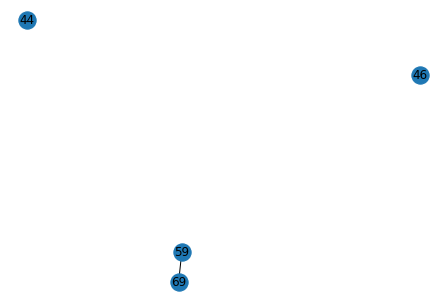

match_branches = [[59, 69]]
edges_to_delete (resolve crossover) = [[44, 46], [44, 59], [44, 69], [46, 59], [46, 69]]
edges_to_create (resolve crossover) = [[59, 69]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [81, 92], [81, 95], [92, 94], [94, 95], [66, 85], [66, 92], [85, 96], [92, 96]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[44, 46], [44, 59], [44, 69], [46, 59], [46, 69]]
edges_to_create = [[59, 69]]
Number of connected components = 14
Comp 0 = {0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 40, 42, 45, 47, 52, 53, 54, 55, 57, 63, 73, 76, 82, 86}
Comp 1 = {3}
Comp 2 = {79}
Comp 3 = {2, 9, 38, 41, 43, 48, 50, 51, 56, 58, 59, 

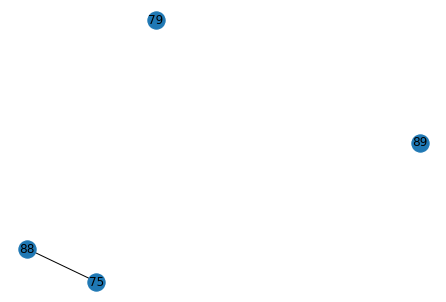

match_branches = [[75, 88]]
edges_to_delete (resolve crossover) = [[75, 79], [75, 89], [79, 88], [79, 89], [88, 89]]
edges_to_create (resolve crossover) = [[75, 88]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [81, 92], [81, 95], [92, 94], [94, 95], [66, 85], [66, 92], [85, 96], [92, 96], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[75, 79], [75, 89], [79, 88], [79, 89], [88, 89]]
edges_to_create = [[75, 88]]
Number of connected components = 14
Comp 0 = {0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 40, 42, 45, 47, 52, 53, 54, 55, 57, 63, 73, 76, 82, 86}
Comp 1 = {3}
Comp 2 = {79}
Co

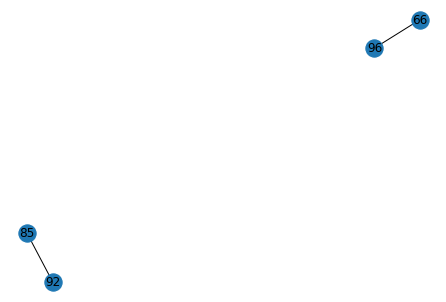

match_branches = [[85, 92], [66, 96]]
edges_to_delete (resolve crossover) = [[66, 85], [66, 92], [85, 96], [92, 96]]
edges_to_create (resolve crossover) = [[85, 92], [66, 96]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [81, 92], [81, 95], [92, 94], [94, 95], [66, 85], [66, 92], [85, 96], [92, 96], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[66, 85], [66, 92], [85, 96], [92, 96]]
edges_to_create = [[85, 92], [66, 96]]
Number of connected components = 14
Comp 0 = {0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 40, 42, 45, 47, 52, 53, 5

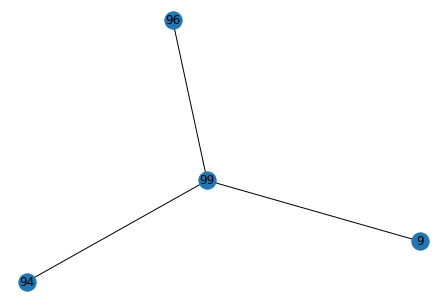

match_branches = [[9, 99]]
edges_to_delete (resolve crossover) = [[9, 94], [9, 96], [94, 96], [94, 99], [96, 99]]
edges_to_create (resolve crossover) = [[9, 99]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [81, 92], [81, 95], [92, 94], [94, 95], [66, 85], [66, 92], [85, 96], [92, 96], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [66, 85], [66, 92], [85, 96], [92, 96]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[9, 94], [9, 96], [94, 96], [94, 99], [96, 99]]
edges_to_create = [[9, 99]]
Number of connected components = 16
Comp 0 = {0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 40

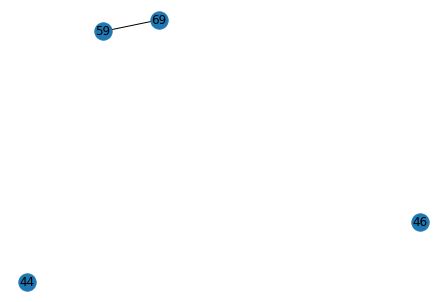

match_branches = [[59, 69]]
edges_to_delete (resolve crossover) = [[44, 46], [44, 59], [44, 69], [46, 59], [46, 69]]
edges_to_create (resolve crossover) = [[59, 69]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [81, 92], [81, 95], [92, 94], [94, 95], [66, 85], [66, 92], [85, 96], [92, 96], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [66, 85], [66, 92], [85, 96], [92, 96], [9, 94], [9, 96], [94, 96], [94, 99], [96, 99]]
Skipping endnode 106 because skeletal distance was 1022.9214048800834 and threshold was 2500
skip_nodes = [106]
edges_to_delete (cut_limb_network) = [[44, 46], [44, 59], [44, 69], [46, 59], [46, 69]]
edges_to_create = [[59, 69]]
Number of connected co

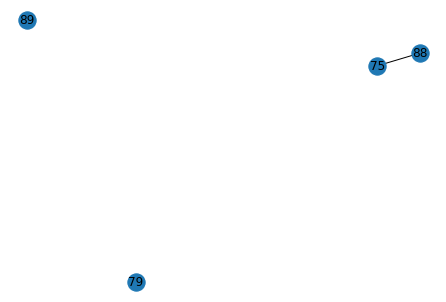

match_branches = [[75, 88]]
edges_to_delete (resolve crossover) = [[75, 79], [75, 89], [79, 88], [79, 89], [88, 89]]
edges_to_create (resolve crossover) = [[75, 88]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [81, 92], [81, 95], [92, 94], [94, 95], [66, 85], [66, 92], [85, 96], [92, 96], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [66, 85], [66, 92], [85, 96], [92, 96], [9, 94], [9, 96], [94, 96], [94, 99], [96, 99], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69]]
Skipping endnode 106 because skeletal distance was 1022.9214048800834 and threshold was 2500
skip_nodes = [106]
edges_to_delete (cut_limb_network) = [[75, 79], [75, 89], [79, 88], [79, 89], [88, 89]]
e

  Edge: [88 75]: curr_angle = 29.73
  Edge: [75 69]: curr_angle = 33.36
  Edge: [69 59]: curr_angle = 12.94
  Edge: [59 65]: curr_angle = 91.48
  Edge: [65 64]: curr_angle = 82.14
  Edge: [64 84]: curr_angle = 38.31
  Edge: [ 84 100]: curr_angle = 65.9

Total time for doubling_back = 0.4298994541168213

Attempting the width jump check (attempting from both sides)
  Edge: [88 75]: jump = -209.76
  Edge: [75 69]: jump = -249.88
  Edge: [69 59]: jump = -40.5
  Edge: [59 65]: jump = -230.38
  Edge: [65 64]: jump = 168.55
  Edge: [64 84]: jump = 66.59
  Edge: [ 84 100]: jump = 280.35
Adding error edge [ 84 100] because width jump was 280.3452113179289
Total time for width = 0.37537550926208496
Path starting at 88 had err_edges: [[84, 100]]
  Edge: [100  84]: jump = -280.35
  Edge: [84 64]: jump = -66.59
  Edge: [64 65]: jump = -200.07
  Edge: [65 59]: jump = 198.87
  Edge: [59 69]: jump = 40.5
  Edge: [69 75]: jump = 249.88
Adding error edge [69 75] because width jump was 249.88422527938945

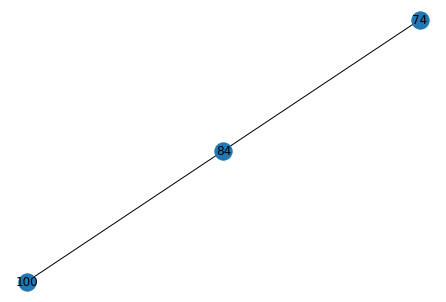

match_branches = [[84, 100]]
edges_to_delete (resolve crossover) = [[74, 84], [74, 100]]
edges_to_create (resolve crossover) = [[84, 100]]
Rejecting creating edge [84, 100] becuase did not involve only 1 node in the deleted edge
edges_to_delete (cut_limb_network) = [array([74, 84]), array([ 74, 100]), array([ 84, 100])]
edges_to_create = []
Number of connected components = 18
Comp 0 = {0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 40, 42, 45, 47, 52, 53, 54, 55, 57, 63, 73, 76, 82, 86}
Comp 1 = {3}
Comp 2 = {79}
Comp 3 = {81, 51, 94}
Comp 4 = {64, 65, 2, 66, 96, 69, 67, 38, 41, 43, 75, 50, 84, 88, 58, 59}
Comp 5 = {68, 72, 80, 83, 89}
Comp 6 = {128, 98, 122, 127, 110, 85, 119, 120, 121, 90, 91, 92, 95}
Comp 7 = {49}
Comp 8 = {18, 36, 37, 61, 70, 71, 78, 93, 101, 102, 103, 104, 107, 108, 109, 111, 112, 113, 114, 115, 117, 118}
Comp 9 = {9, 99}
Comp 10 = {44}
Comp 11 = {46}
Comp 12 = {56, 74, 60}
Comp 13 = {10

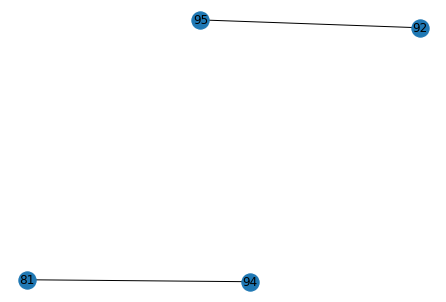

match_branches = [[81, 94], [92, 95]]
edges_to_delete (resolve crossover) = [[81, 92], [81, 95], [92, 94], [94, 95]]
edges_to_create (resolve crossover) = [[81, 94], [92, 95]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [81, 92], [81, 95], [92, 94], [94, 95], [66, 85], [66, 92], [85, 96], [92, 96], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [66, 85], [66, 92], [85, 96], [92, 96], [9, 94], [9, 96], [94, 96], [94, 99], [96, 99], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], array([74, 84]), array([ 74, 100]), array([ 84, 100])]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[81, 92], [81, 95], [92, 94], [9

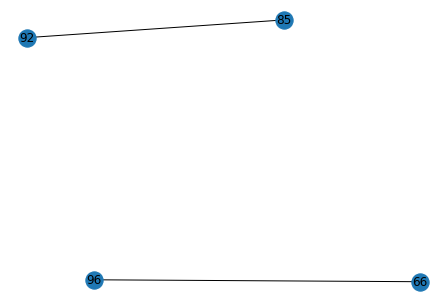

match_branches = [[85, 92], [66, 96]]
edges_to_delete (resolve crossover) = [[66, 85], [66, 92], [85, 96], [92, 96]]
edges_to_create (resolve crossover) = [[85, 92], [66, 96]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [81, 92], [81, 95], [92, 94], [94, 95], [66, 85], [66, 92], [85, 96], [92, 96], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [66, 85], [66, 92], [85, 96], [92, 96], [9, 94], [9, 96], [94, 96], [94, 99], [96, 99], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], array([74, 84]), array([ 74, 100]), array([ 84, 100]), [81, 92], [81, 95], [92, 94], [94, 95]]
skip_nodes = []
edges_to_delete (cut_limb_netw

  Edge: [95 92]: curr_angle = 21.69
  Edge: [92 85]: curr_angle = 5.52
  Edge: [85 98]: curr_angle = 10.57
  Edge: [ 98 110]: curr_angle = 99.71
  Edge: [110 121]: curr_angle = 25.41
  Edge: [121 119]: curr_angle = 44.63

Total time for doubling_back = 0.6704363822937012

Attempting the width jump check (attempting from both sides)
  Edge: [95 92]: jump = -14.79
  Edge: [92 85]: jump = 18.11
  Edge: [85 98]: jump = -55.27
  Edge: [ 98 110]: jump = 253.7
Adding error edge [ 98 110] because width jump was 253.70016712862792
  Edge: [110 121]: jump = -185.06
  Edge: [121 119]: jump = 155.32
Total time for width = 0.6965088844299316
Path starting at 95 had err_edges: [[98, 110]]
  Edge: [119 121]: jump = -155.32
  Edge: [121 110]: jump = 185.06
  Edge: [110  98]: jump = -253.7
  Edge: [98 85]: jump = 55.27
  Edge: [85 92]: jump = -18.11
  Edge: [92 95]: jump = 14.79
Total time for width = 0.582115650177002
Path starting at 119 had err_edges: []
first_error_sizes = [253.70016712862792, -inf

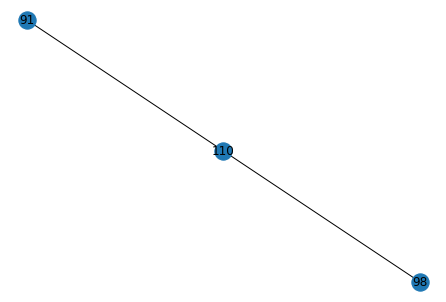

match_branches = [[91, 98]]
edges_to_delete (resolve crossover) = [[91, 110], [98, 110]]
edges_to_create (resolve crossover) = [[91, 98]]
edges_to_delete (cut_limb_network) = [array([ 91, 110]), array([ 98, 110])]
edges_to_create = [[91, 98]]
Number of connected components = 19
Comp 0 = {0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 40, 42, 45, 47, 52, 53, 54, 55, 57, 63, 73, 76, 82, 86}
Comp 1 = {3}
Comp 2 = {79}
Comp 3 = {81, 51, 94}
Comp 4 = {64, 65, 2, 66, 96, 69, 67, 38, 41, 75, 43, 50, 84, 88, 58, 59}
Comp 5 = {68, 72, 80, 83, 89}
Comp 6 = {98, 85, 90, 91, 92, 95}
Comp 7 = {49}
Comp 8 = {18, 36, 37, 61, 70, 71, 78, 93, 101, 102, 103, 104, 107, 108, 109, 111, 112, 113, 114, 115, 117, 118}
Comp 9 = {9, 99}
Comp 10 = {44}
Comp 11 = {46}
Comp 12 = {128, 110, 119, 120, 121, 122, 127}
Comp 13 = {56, 74, 60}
Comp 14 = {100, 105, 106, 48, 116, 123, 124, 125, 126}
Comp 15 = {62}
Comp 16 = {77}
Comp 17 = {87}
Co

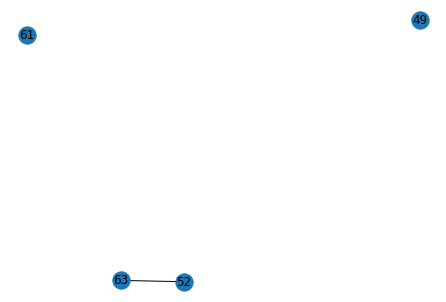

match_branches = [[52, 63]]
edges_to_delete (resolve crossover) = [[49, 52], [49, 61], [49, 63], [52, 61], [61, 63]]
edges_to_create (resolve crossover) = [[52, 63]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [81, 92], [81, 95], [92, 94], [94, 95], [66, 85], [66, 92], [85, 96], [92, 96], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [66, 85], [66, 92], [85, 96], [92, 96], [9, 94], [9, 96], [94, 96], [94, 99], [96, 99], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], array([74, 84]), array([ 74, 100]), array([ 84, 100]), [81, 92], [81, 95], [92, 94], [94, 95], [66, 85], [66, 92], [85, 96], [92, 96], array([ 91, 110]

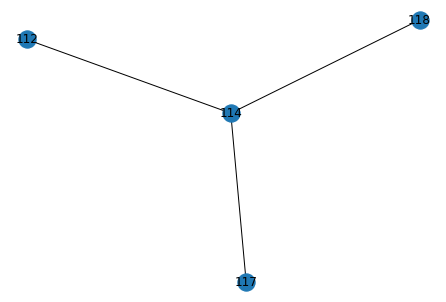

match_branches = [[112, 117]]
edges_to_delete (resolve crossover) = [[112, 114], [112, 118], [114, 117], [114, 118], [117, 118]]
edges_to_create (resolve crossover) = [[112, 117]]
curr_limb.deleted_edges 5 =[[3, 57], [3, 76], [3, 79], [57, 79], [76, 79], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [51, 73], [51, 82], [73, 81], [81, 82], [49, 52], [49, 61], [49, 63], [52, 61], [61, 63], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [81, 92], [81, 95], [92, 94], [94, 95], [66, 85], [66, 92], [85, 96], [92, 96], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], [66, 85], [66, 92], [85, 96], [92, 96], [9, 94], [9, 96], [94, 96], [94, 99], [96, 99], [44, 46], [44, 59], [44, 69], [46, 59], [46, 69], [75, 79], [75, 89], [79, 88], [79, 89], [88, 89], array([74, 84]), array([ 74, 100]), array([ 84, 100]), [81, 92], [81, 95], [92, 94], [94, 95], [66, 85], [66, 92], [85, 96], [92, 96], ar

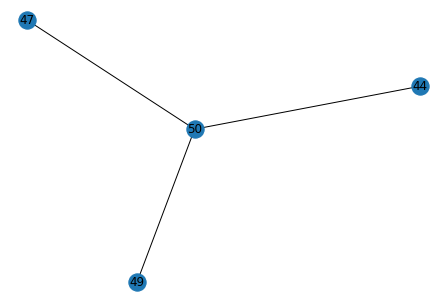

match_branches = [[47, 49]]
edges_to_delete (resolve crossover) = [[44, 47], [44, 49], [44, 50], [47, 50], [49, 50]]
edges_to_create (resolve crossover) = [[47, 49]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 50 because skeletal distance was 703.2521986290564 and threshold was 2500
skip_nodes = [50]
edges_to_delete (cut_limb_network) = [[44, 47], [44, 49], [44, 50], [47, 50], [49, 50]]
edges_to_create = [[47, 49]]
Number of connected components = 3
Comp 0 = {50}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49.0, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62}
Comp 2 = {48}
curr_limb_copy.deleted_edges = [[44, 47], [44, 49], [44, 50], [47, 50], [49, 50]]
curr_limb_copy.created_edges = [[47, 49]]
After get best cut: cut_edges = [[44, 47], [44, 49], [44, 50], [47, 50], [49, 50]], added_edges = [[47, 49]]
total_soma_paths_to_cut = []
-------

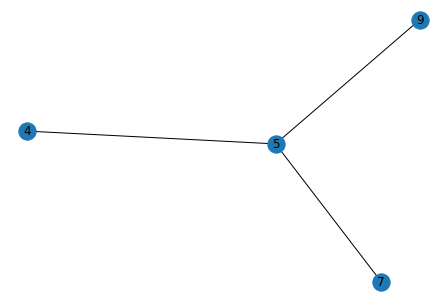

match_branches = [[5, 9]]
edges_to_delete (resolve crossover) = [[4, 5], [4, 7], [4, 9], [5, 7], [7, 9]]
edges_to_create (resolve crossover) = [[5, 9]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[4, 5], [4, 7], [4, 9], [5, 7], [7, 9]]
edges_to_create = [[5, 9]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
Comp 1 = {4}
Comp 2 = {6}
curr_limb_copy.deleted_edges = [[4, 5], [4, 7], [4, 9], [5, 7], [7, 9]]
curr_limb_copy.created_edges = [[5, 9]]
After get best cut: cut_edges = [[4, 5], [4, 7], [4, 9], [5, 7], [7, 9]], added_edges = [[5, 9]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path

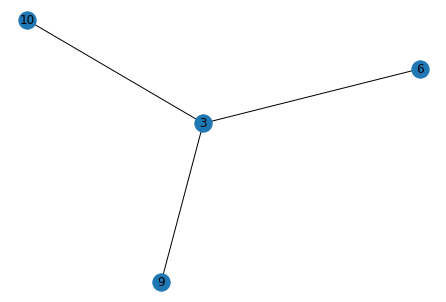

match_branches = [[3, 9]]
edges_to_delete (resolve crossover) = [[3, 6], [3, 10], [6, 9], [6, 10], [9, 10]]
edges_to_create (resolve crossover) = [[3, 9]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[3, 6], [3, 10], [6, 9], [6, 10], [9, 10]]
edges_to_create = [[3, 9]]
Number of connected components = 4
Comp 0 = {1, 4, 5, 6, 7}
Comp 1 = {0, 9, 2, 3}
Comp 2 = {10}
Comp 3 = {8}
curr_limb_copy.deleted_edges = [[3, 6], [3, 10], [6, 9], [6, 10], [9, 10]]
curr_limb_copy.created_edges = [[3, 9]]
After get best cut: cut_edges = [[3, 6], [3, 10], [6, 9], [6, 10], [9, 10]], added_edges = [[3, 9]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 4: [array([1, 4, 5, 6, 7]), array([0, 9, 2, 3]), 

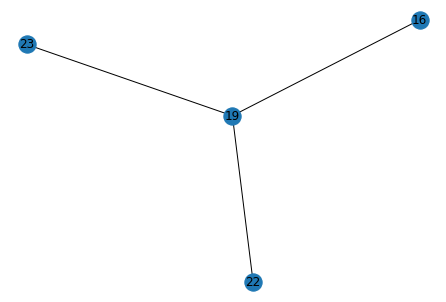

match_branches = [[19, 22]]
edges_to_delete (resolve crossover) = [[16, 19], [16, 22], [16, 23], [19, 23], [22, 23]]
edges_to_create (resolve crossover) = [[19, 22]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[16, 19], [16, 22], [16, 23], [19, 23], [22, 23]]
edges_to_create = [[19, 22]]
Number of connected components = 3
Comp 0 = {16}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 

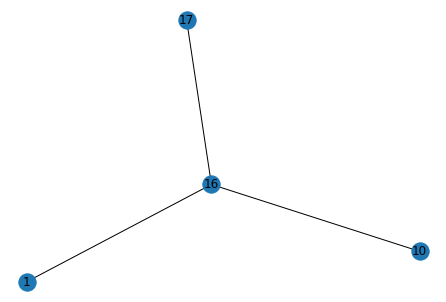

match_branches = [[1, 17], [10, 16]]
edges_to_delete (resolve crossover) = [[1, 10], [1, 16], [10, 17], [16, 17]]
edges_to_create (resolve crossover) = [[1, 17], [10, 16]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 10], [1, 16], [10, 17], [16, 17]]
edges_to_create = [[1, 17], [10, 16]]
Number of connected components = 2
Comp 0 = {0, 2, 4, 5, 6, 7, 9, 10, 16, 18, 19, 20, 21, 22, 25, 26}
Comp 1 = {1, 3, 8, 11, 12, 13, 14, 15, 17, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39}
curr_limb_copy.deleted_edges = [[1, 10], [1, 16], [10, 17], [16, 17]]
curr_limb_copy.created_edges = [[1, 17], [10, 16]]
After get best cut: cut_edges = [[1, 10], [1, 16], [10, 17], [16, 17]], added_edges = [[1, 17], [10, 16]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so

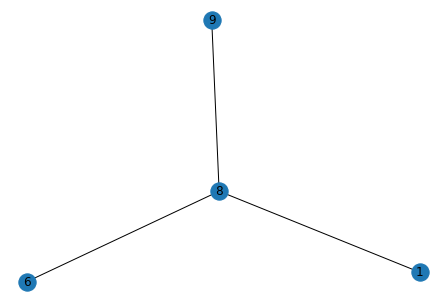

match_branches = [[1, 8], [6, 9]]
edges_to_delete (resolve crossover) = [[1, 6], [1, 9], [6, 8], [8, 9]]
edges_to_create (resolve crossover) = [[1, 8], [6, 9]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 6], [1, 9], [6, 8], [8, 9]]
edges_to_create = [[1, 8], [6, 9]]
Number of connected components = 2
Comp 0 = {0, 2, 3, 4, 5, 6, 9, 11}
Comp 1 = {8, 1, 10, 7}
curr_limb_copy.deleted_edges = [[1, 6], [1, 9], [6, 8], [8, 9]]
curr_limb_copy.created_edges = [[1, 8], [6, 9]]
After get best cut: cut_edges = [[1, 6], [1, 9], [6, 8], [8, 9]], added_edges = [[1, 8], [6, 9]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  2,  3,  4,  5,  6,  9, 11]), array([ 8,  1, 10,  7])]

  Edge: [77 71]: curr_angle = 72.78
  Edge: [71 67]: curr_angle = 46.39
  Edge: [67 69]: curr_angle = 27.19
  Edge: [ 69 111]: curr_angle = 48.89
  Edge: [111  98]: curr_angle = 140.89
  Edge: [98 93]: curr_angle = 49.95

Total time for doubling_back = 0.4997725486755371
There were 1 edges that passed doubling back threshold of 100
Winning edge [111  98] had a doubling back of 140.89239757896314
***inside resolve crossover!!!!****
coordinate_branches = [98, 110, 111]
98 = red
110 = aqua
111 = purple
Angle between 98 and 110 = 24.84 
Angle between 98 and 111 = 107.02 
Angle between 110 and 111 = 48.36 
Final Matches = [[98, 110]]
matched_branches_revised = [[98, 110]]
Original graph


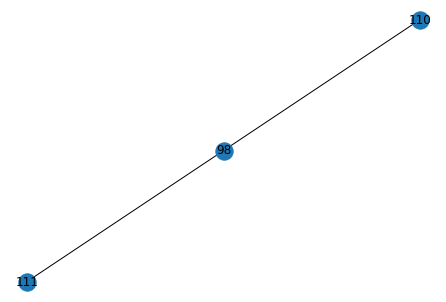

match_branches = [[98, 110]]
edges_to_delete (resolve crossover) = [[98, 111], [110, 111]]
edges_to_create (resolve crossover) = [[98, 110]]
edges_to_delete (cut_limb_network) = [array([ 98, 111]), array([110, 111])]
edges_to_create = [[98, 110]]
Number of connected components = 2
Comp 0 = {0, 2, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118}
Comp 1 = {1, 98, 3, 4, 6, 8, 110, 93, 94, 95}
curr_limb_copy.deleted_edges = [array([ 98, 111]), array([110, 111])]
curr_limb_copy.created_edges = [[98, 110]]
After get best cut: cut_edges = [array([ 98, 111]), array([110, 111])], added_edges = [[98, 110]]
to

  Edge: [77 71]: curr_angle = 72.78
  Edge: [71 83]: curr_angle = 74.73
  Edge: [83 96]: curr_angle = 75.56
  Edge: [ 96 117]: curr_angle = 82.63
  Edge: [117  99]: curr_angle = 109.66
  Edge: [ 99 100]: curr_angle = 92.93
  Edge: [100 102]: curr_angle = 32.69

Total time for doubling_back = 0.13562464714050293
There were 1 edges that passed doubling back threshold of 100
Winning edge [117  99] had a doubling back of 109.66009232087957
***inside resolve crossover!!!!****
coordinate_branches = [99, 101, 117]
99 = red
101 = aqua
117 = purple
Angle between 99 and 101 = 5.62 
Angle between 99 and 117 = 103.29 
Angle between 101 and 117 = 75.54 
Final Matches = [[99, 101]]
matched_branches_revised = [[99, 101]]
Original graph


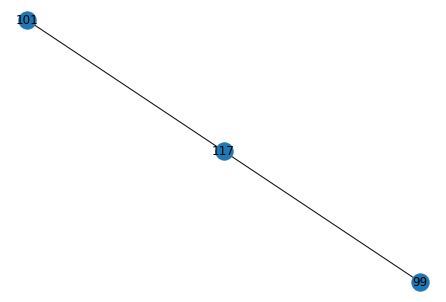

match_branches = [[99, 101]]
edges_to_delete (resolve crossover) = [[99, 117], [101, 117]]
edges_to_create (resolve crossover) = [[99, 101]]
edges_to_delete (cut_limb_network) = [array([ 99, 117]), array([101, 117])]
edges_to_create = [[99, 101]]
Number of connected components = 3
Comp 0 = {97, 99, 100, 101, 102, 103, 9, 11, 76, 80, 88, 89}
Comp 1 = {0, 2, 5, 7, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 90, 91, 92, 96, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118}
Comp 2 = {1, 98, 3, 4, 6, 8, 110, 93, 94, 95}
curr_limb_copy.deleted_edges = [array([ 98, 111]), array([110, 111]), array([ 99, 117]), array([101, 117])]
curr_limb_copy.created_edges = [[98, 110], [99, 101]]
After get best cut: cut_edges = [array([ 

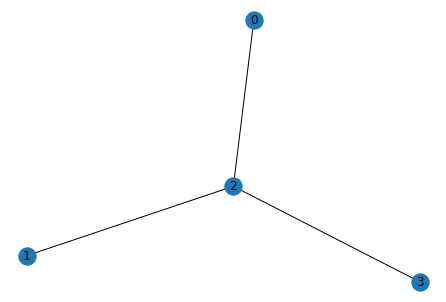

match_branches = [[1, 2], [0, 3]]
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [1, 3], [2, 3]]
edges_to_create (resolve crossover) = [[1, 2], [0, 3]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[0, 1], [0, 2], [1, 3], [2, 3]]
edges_to_create = [[1, 2], [0, 3]]
Number of connected components = 2
Comp 0 = {1, 2}
Comp 1 = {0, 3, 4, 5, 6, 7}
curr_limb_copy.deleted_edges = [[0, 1], [0, 2], [1, 3], [2, 3]]
curr_limb_copy.created_edges = [[1, 2], [0, 3]]
After get best cut: cut_edges = [[0, 1], [0, 2], [1, 3], [2, 3]], added_edges = [[1, 2], [0, 3]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([1, 2]), array([0, 3, 4, 5, 6, 7])]


 ------ Total time for Splitting 86

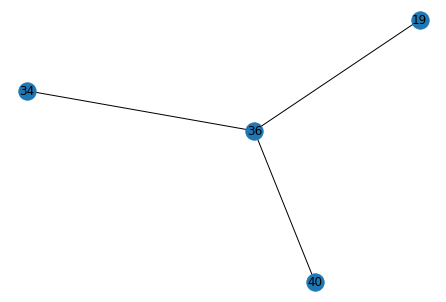

match_branches = [[34, 36]]
edges_to_delete (resolve crossover) = [[19, 34], [19, 36], [19, 40], [34, 40], [36, 40]]
edges_to_create (resolve crossover) = [[34, 36]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[19, 34], [19, 36], [19, 40], [34, 40], [36, 40]]
edges_to_create = [[34, 36]]
Number of connected components = 5
Comp 0 = {0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 72, 73, 74, 75, 81, 83, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}
Comp 1 = {19}
Comp 2 = {68, 69, 6, 71, 40, 8, 7, 76, 78, 79, 80, 82, 84, 87, 55}
Comp 3 = {38}
Comp 4 = {77}
curr_limb_copy.deleted_edges = [[19, 34], [19, 36], [19, 40], [34, 40], [36, 40]]
curr_limb_copy.created_edges = [[34, 36]]
After get best cut: cut_edges = [[19, 34], [19, 36], [19, 40], [34,

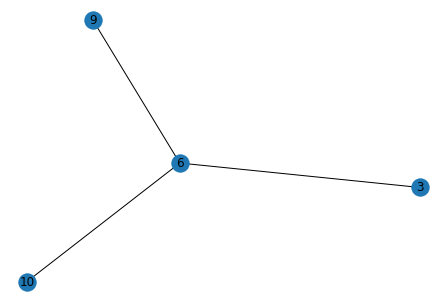

match_branches = [[6, 9], [3, 10]]
edges_to_delete (resolve crossover) = [[3, 6], [3, 9], [6, 10], [9, 10]]
edges_to_create (resolve crossover) = [[6, 9], [3, 10]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[3, 6], [3, 9], [6, 10], [9, 10]]
edges_to_create = [[6, 9], [3, 10]]
Number of connected components = 2
Comp 0 = {0, 2, 3, 8, 10, 11, 12, 15, 16, 17, 19, 20, 22}
Comp 1 = {1, 4, 5, 6, 7, 9, 13, 14, 18, 21}
curr_limb_copy.deleted_edges = [[3, 6], [3, 9], [6, 10], [9, 10]]
curr_limb_copy.created_edges = [[6, 9], [3, 10]]
After get best cut: cut_edges = [[3, 6], [3, 9], [6, 10], [9, 10]], added_edges = [[6, 9], [3, 10]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 

  Edge: [1 3]: curr_angle = 51.74
  Edge: [ 3 10]: curr_angle = 39.19
  Edge: [10  6]: curr_angle = 120.38
  Edge: [6 4]: curr_angle = 39.83

Total time for doubling_back = 0.33342933654785156
There were 1 edges that passed doubling back threshold of 100
Winning edge [10  6] had a doubling back of 120.37992026839595
***inside resolve crossover!!!!****
coordinate_branches = [6, 10, 12]
6 = red
10 = aqua
12 = purple
Angle between 6 and 10 = 78.84 
Angle between 6 and 12 = 26.1 
Angle between 10 and 12 = 92.76 
Final Matches = [[6, 12]]
matched_branches_revised = [[6, 12]]
Original graph


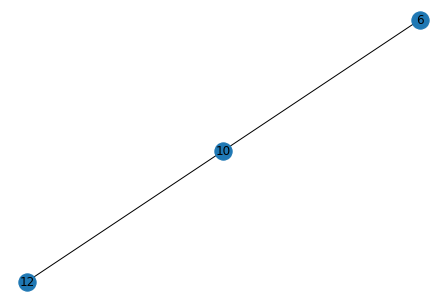

match_branches = [[6, 12]]
edges_to_delete (resolve crossover) = [[6, 10], [10, 12]]
edges_to_create (resolve crossover) = [[6, 12]]
edges_to_delete (cut_limb_network) = [array([ 6, 10]), array([10, 12])]
edges_to_create = [[6, 12]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 5, 7, 8, 10, 11, 13, 14}
Comp 1 = {9, 4, 12, 6}
curr_limb_copy.deleted_edges = [array([ 6, 10]), array([10, 12])]
curr_limb_copy.created_edges = [[6, 12]]
After get best cut: cut_edges = [array([ 6, 10]), array([10, 12])], added_edges = [[6, 12]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  3,  5,  7,  8, 10, 11, 13, 14]), array([ 9,  4, 12,  6])]


 ------ Total time for Splitting 864691136908675694 = 48.5730

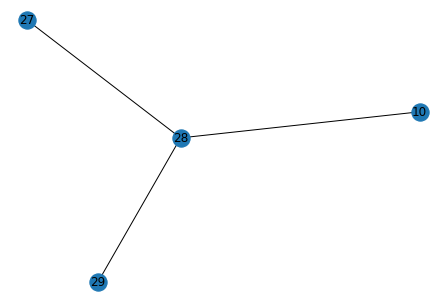

match_branches = [[10, 29]]
edges_to_delete (resolve crossover) = [[10, 27], [10, 28], [27, 28], [27, 29], [28, 29]]
edges_to_create (resolve crossover) = [[10, 29]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 70 because skeletal distance was 1290.7419653997445 and threshold was 2500
skip_nodes = [70]
edges_to_delete (cut_limb_network) = [[10, 27], [10, 28], [27, 28], [27, 29], [28, 29]]
edges_to_create = [[10, 29]]
Number of connected components = 3
Comp 0 = {2, 41, 11, 43, 28}
Comp 1 = {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89}
Comp 2 = {27}
curr_limb_copy.deleted_edges = [[10, 27], [10, 28], [27, 28], [27, 29], [28, 29]]
curr_limb_copy.created_edges = [[10, 29]]
After get best cut: cut_edges = [[10, 

  Edge: [72 65]: curr_angle = 45.17
  Edge: [65 64]: curr_angle = 24.16
  Edge: [64 71]: curr_angle = 129.23
  Edge: [71 73]: curr_angle = 58.14
  Edge: [73 93]: curr_angle = 38.82
  Edge: [ 93 100]: curr_angle = 17.09

Total time for doubling_back = 0.525078535079956
There were 1 edges that passed doubling back threshold of 100
Winning edge [64 71] had a doubling back of 129.22890386420195
***inside resolve crossover!!!!****
coordinate_branches = [64, 67, 71]
64 = red
67 = aqua
71 = purple
Angle between 64 and 67 = 5.35 
Angle between 64 and 71 = 117.77 
Angle between 67 and 71 = 59.71 
Final Matches = [[64, 67]]
matched_branches_revised = [[64, 67]]
Original graph


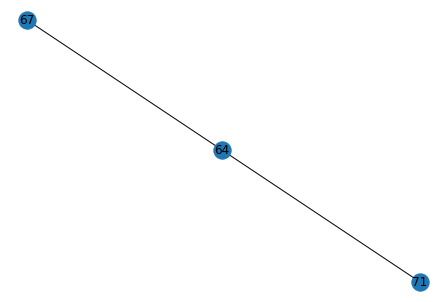

match_branches = [[64, 67]]
edges_to_delete (resolve crossover) = [[64, 71], [67, 71]]
edges_to_create (resolve crossover) = [[64, 67]]
edges_to_delete (cut_limb_network) = [array([64, 71]), array([67, 71])]
edges_to_create = [[64, 67]]
Number of connected components = 2
Comp 0 = {8, 10, 11, 12, 13, 14, 17, 18, 19, 23, 26, 34, 35, 36, 37, 71, 73, 78, 90, 91, 92, 93, 98, 99, 100}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 9, 15, 16, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 94, 95, 96, 97, 101, 102, 103, 104, 105, 106, 107}
curr_limb_copy.deleted_edges = [array([64, 71]), array([67, 71])]
curr_limb_copy.created_edges = [[64, 67]]
After get best cut: cut_edges = [array([64, 71]), array([67, 71])], added_edges = [[64, 67]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteratio

  Edge: [18 17]: curr_angle = 26.37
  Edge: [17 16]: curr_angle = 40.34
  Edge: [16 14]: curr_angle = 39.74
  Edge: [14 34]: curr_angle = 13.99
  Edge: [34 37]: curr_angle = 18.39

Total time for doubling_back = 0.5511746406555176

Attempting the width jump check (attempting from both sides)
  Edge: [18 17]: jump = -418.41
  Edge: [17 16]: jump = -276.88
  Edge: [16 14]: jump = 9.06
  Edge: [14 34]: jump = -56.1
  Edge: [34 37]: jump = 276.08
Adding error edge [34 37] because width jump was 276.07739192131714
Total time for width = 0.3847823143005371
Path starting at 18 had err_edges: [[34, 37]]
  Edge: [37 34]: jump = -276.08
  Edge: [34 14]: jump = 56.1
  Edge: [14 16]: jump = -9.06
  Edge: [16 17]: jump = 276.88
Adding error edge [16 17] because width jump was 276.88387968003497
Populate Done
Total time for NeuronSplitSuggestions populate = 4172.660716295242


In [11]:
start_time = time.time()
if not test_mode:
    time.sleep(random.randint(0, 800))
print('Populate Started')
if not test_mode:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
else:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
print('Populate Done')

print(f"Total time for NeuronSplitSuggestions populate = {time.time() - start_time}")